# Manuel Romero García
## Máster en Big Data y Data Science UCM
### Tarea Text Mining

### 0. Importación

In [47]:
import sys
import os
import pandas as pd
def get_tweet_content(list_paths):
  """
    Función para guardar en un diccionario el contenido de archivos txt 
    que se introduce en su entrada. 
    Devuelve un diccionario en el que las claves son el id del tweet, y
    el valor el texto del tweet.
  """
  output_dict = dict()
  for i in list_paths:
    tweet_id = i.split("/")[-1].split(".txt")[0]
    with open(i, encoding='utf-8') as f:
        output_dict[int(tweet_id)] = f.read()
  
  return output_dict

def get_profner_data(profner_path_data):
    # Obtenemos el path a los txt de los tweets.
    path_to_txt = profner_path_data+"subtask-1/train-valid-txt-files/"
    tweets_train_files = [path_to_txt+"train/"+i for i in os.listdir(path_to_txt+"train/")]
    tweets_valid_files = [path_to_txt+"valid/"+i for i in os.listdir(path_to_txt+"valid/")]
    # Obtenemos diccionarios en los que el key es el tweet_id y el value el texto del tweet.
    train_txt_content = get_tweet_content(tweets_train_files)
    valid_txt_content = get_tweet_content(tweets_valid_files)

    # Cargamos dos dataframes con los tweet_id y la categoría de los tweets
    path_to_labeled = profner_path_data+"subtask-1/"
    train_tweets = pd.read_csv(path_to_labeled+"train.tsv",sep="\t")
    valid_tweets = pd.read_csv(path_to_labeled+"valid.tsv",sep="\t")

    # Introducimos a los df el campo de texto mapeando los diccionarios con tweet_id
    train_tweets["tweet_text"] = train_tweets['tweet_id'].map(train_txt_content)
    train_tweets["set"] = "train"
    valid_tweets["tweet_text"] = valid_tweets['tweet_id'].map(valid_txt_content)
    valid_tweets["set"] = "valid"

    # Concatenamos el resultado
    output_df = pd.concat([train_tweets,valid_tweets],axis=0)
    # Eliminamos retorno de carro
    output_df["tweet_text"] = output_df.tweet_text.apply(lambda x: x.replace('\n', ' '))
    return output_df[["tweet_id","tweet_text","label","set"]].reset_index(drop=True)

In [48]:
df = get_profner_data('C:\\Users\\mromg\\Documents\\profner\\')
df

,tweet_id,tweet_text,label,set
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0,train
...,...,...,...,...
7995,1263939682662002689,#LoMásLeído | Los nuevos infectados de coronav...,0,valid
7996,1259976635891306516,Ayuso adjudica a dedo un contrato de 30.000 eu...,1,valid
7997,1277128552153055232,Meses encerrados. Se puede viajar a otras prov...,0,valid
7998,1267915731422916613,El gobierno prohíbe por ley lis despidos duran...,0,valid


### 1. Limpieza y exploración de datos

In [49]:
import nltk
from nltk.corpus import stopwords
import re 
from nltk.stem import SnowballStemmer
nltk.download('punkt')
from unidecode import unidecode

# Create an instance of the SnowballStemmer class for Spanish
stemmer = SnowballStemmer('spanish')
# limpieza personalizada (lejos de estar muy bien, pero creo que es mejor utilizar regex siempre que se pueda)

stop_words = list(stopwords.words('spanish'))

def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    # eliminación de emojis
    emoji_pattern = re.compile("["
    u"\U0001F300-\U0001F6FF"  # symbols & pictographs
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u'\u2600-\u26FF\u2700-\u27BF'
    u'\u2934' u'\u2935' u'\u2B05' u'\u2B06' u'\u2B07' u'\u2B1B' u'\u2B1C' 
    u'\u2B50' u'\u2B55' u'\u3030' u'\u303D' u'\u3297' u'\u3299' u'\u00A9'
    u'\u00AE' u'\u203C' u'\u2049' u'\u2122' u'\u2139' u'\u2194-\u2199' 
    u'\u21A9' u'\u21AA' u'\u231A' u'\u231B' u'\u2328' u'\u23CF'
    u'\u23E9-\u23F3' u'\u23F8' u'\u23F9' u'\u23FA' u'\u24C2' u'\u25AA'
    u'\u25AB' u'\u25B6' u'\u25C0' u'\u25FB' u'\u25FD' u'\u25FC' u'\u25FE'
    ']+', flags=re.UNICODE)
        
    nuevo_texto = re.sub(emoji_pattern,r' ',texto)
    # Se convierte todo el texto a minúsculas
    nuevo_texto = nuevo_texto.lower()
    # se eliminan acentos
    nuevo_texto = unidecode(nuevo_texto)
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    #Eliminación todos los caracteres no alfanuméricos:
    nuevo_texto = re.sub(r'[^a-zA-Z0-9\s]', '', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminamos stopwords en español
    nuevo_texto = [token for token in nuevo_texto if token not in stop_words]
    # Eliminación de tokens con una longitud < 3
    nuevo_texto = [token for token in nuevo_texto if len(token) > 2]
    # stemm en español
    nuevo_texto = [stemmer.stem(token) for token in nuevo_texto]
    return(nuevo_texto)

df['tweet_text_clean'] = df['tweet_text'].apply(lambda x: limpiar_tokenizar(x))
df[['tweet_text','tweet_text_clean']].head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mromg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,tweet_text,tweet_text_clean
0,CHINA: libera una pandemia EE.UU: libera OVNIS...,"[chin, liber, pandemi, eeuu, liber, ovnis, arg..."
1,San Francisco (EEUU) hace 100 años tras vivir ...,"[san, francisc, eeuu, hac, anos, tras, viv, pa..."
2,Porfi poneos la mascarilla o tendremos 28 nuev...,"[porfi, pone, mascarill, nuev, cancion, artist..."
3,El nuevo „covid normas y reglas recibimiento“ ...,"[nuev, cov, norm, regl, recib, comerci, minor,..."
4,Si el confinamiento ha dejado algo tocada tu e...,"[confin, dej, toc, estabil, mental, siempr, pu..."


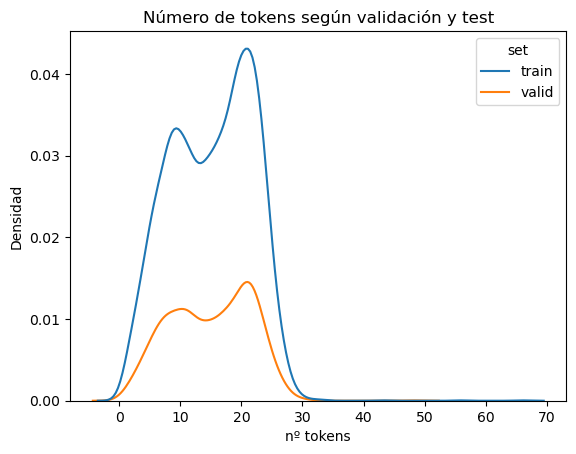

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
df['number_tokens'] = df['tweet_text_clean'].apply(len)

sns.kdeplot(x=df['number_tokens'], hue=df['set'])
plt.title("Número de tokens según validación y test")
plt.xlabel("nº tokens")
plt.ylabel("Densidad")

# afortunadamente, son similares
plt.show()

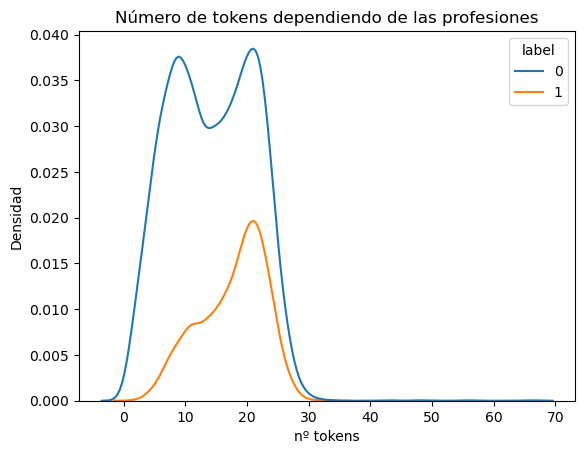

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
df['number_tokens'] = df['tweet_text_clean'].apply(len)

sns.kdeplot(x=df['number_tokens'], hue=df['label'])
plt.title("Número de tokens dependiendo de las profesiones")
plt.xlabel("nº tokens")
plt.ylabel("Densidad")

plt.show()

In [52]:
from scipy.stats import ttest_ind
numerical_var_cat1 = df.loc[df['label'] == 0, 'number_tokens']
numerical_var_cat2 = df.loc[df['label'] == 1, 'number_tokens']

t_stat, p_val = ttest_ind(numerical_var_cat1, numerical_var_cat2)

print('T-Statistic:', t_stat)
print('P-Value:', p_val)

# Parece que la variable de número de tokens es relevante para diferenciar entre si los tweets mencionan profesiones o no, confirmando lo visto arriba en el gráfico

T-Statistic: -19.81925926124452
P-Value: 2.2205778955706776e-85


#### Parece que los tweets que mencionan profesiones son mucho menores que los que no las menciones, así que el modelo tendrá que ser rebalanceado. Por otra parte parece que la distribución de los tweets que no mencionan profesiones es bimodal

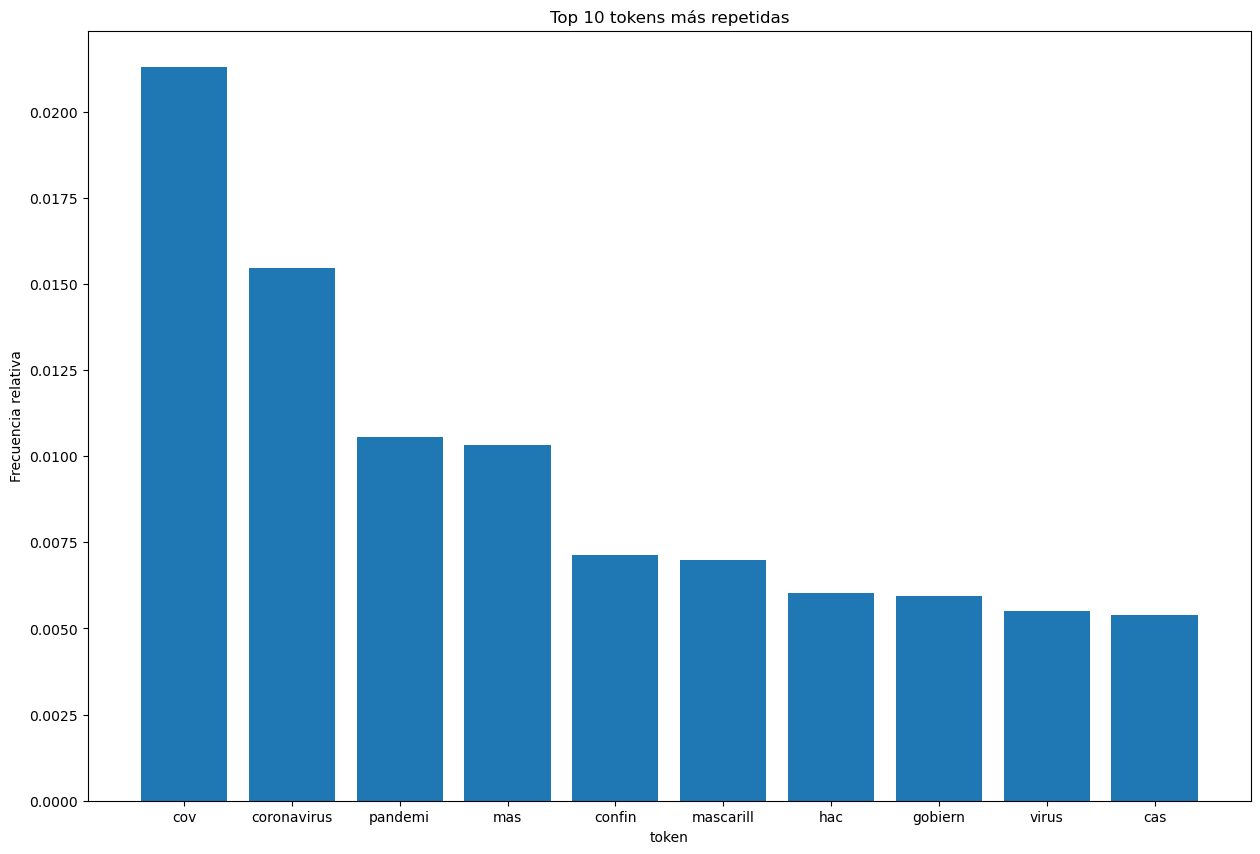

In [53]:
element_counts = {}
total_elements = 0
for row in df['tweet_text_clean']:
    for element in row:
        total_elements += 1
        if element not in element_counts:
            element_counts[element] = 1
        else:
            element_counts[element] += 1

sorted_counts = sorted(element_counts.items(), key=lambda x: x[1], reverse=True)

top_elements = dict(sorted_counts[:10])
relative_frequencies = [count/total_elements for count in top_elements.values()]
plt.figure(figsize=(15, 10))
plt.bar(top_elements.keys(), relative_frequencies)
plt.title('Top 10 tokens más repetidas')
plt.xlabel('token')
plt.ylabel('Frecuencia relativa')
plt.show()

### 2. Sentimientos y vectorización

#### Sentimientos en español

In [54]:
url_path = "https://www.cic.ipn.mx/~sidorov/SEL.txt"
sel_lexicon = pd.read_csv(url_path,sep="\t", encoding="latin-1")
sel_lexicon.head()

,Palabra,PFA,Categoría
0,abundancia,0.830,Alegría
1,acabalar,0.396,Alegría
2,acallar,0.198,Alegría
3,acatar,0.198,Alegría
4,acción,0.397,Alegría


In [55]:
sel_lexicon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Palabra    2036 non-null   object 
 1    PFA       2036 non-null   float64
 2   Categoría  2036 non-null   object 
dtypes: float64(1), object(2)
memory usage: 47.8+ KB


In [56]:
dicc_mapping = {"Alegría":"positive",
                "Sorpresa":"positive",
                "Tristeza":"negative",
                "Enojo":"negative",
                "Miedo":"negative",
                "Repulsión":"negative"}
                
sel_lexicon["Categoría"] = sel_lexicon["Categoría"].map(dicc_mapping)

In [57]:
positive_words = dict(zip(sel_lexicon[sel_lexicon["Categoría"]=="positive"].Palabra, sel_lexicon[sel_lexicon["Categoría"]=="positive"][' PFA']))
negative_words = dict(zip(sel_lexicon[sel_lexicon["Categoría"]=="negative"].Palabra, sel_lexicon[sel_lexicon["Categoría"]=="negative"][' PFA']))

In [58]:
def calculate_sentiment(frase, positive_words=positive_words, negative_words=negative_words):
  """
  Función para calcular el score de sentimiento de una frase

  Args:
    frase [str]: Frase pre-preprocesada en español. Debe venir lematizada.
    positive_words [dict]: Diccionario de palabras positivas extraidas de SEL
    negative_words [dict]: Diccionario de palabras negativas extraídas de SEL

  Out:
    Sentiment score  
  """
  score = 0
  for i in frase.split():
    if i in positive_words:
      score = score + float(positive_words[i])
    elif i in negative_words:
      score = score - float(negative_words[i])
    else:
      score = score + 0
  
  return score


In [59]:
df['sentiment'] = df['tweet_text_clean'].apply(lambda x: calculate_sentiment(' '.join(x))) 
# aplicamos la función sobre otra función que une los tokens como lista
df['sentiment'].value_counts()

 0.000    6812
-0.696     310
 0.798     130
-0.431     103
 0.198      65
          ... 
 0.996       1
 2.329       1
-1.932       1
-2.289       1
 0.132       1
Name: sentiment, Length: 143, dtype: int64

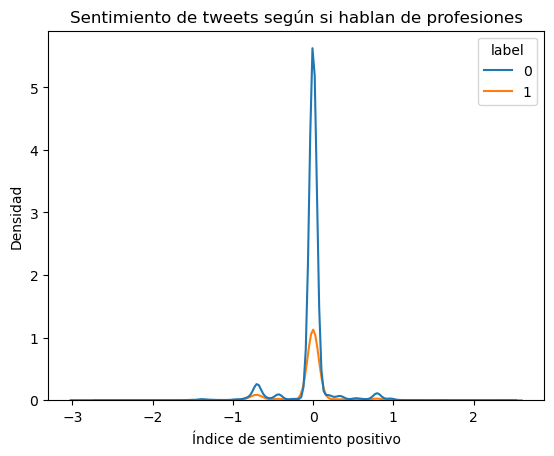

In [60]:
sns.kdeplot(x=df['sentiment'], hue=df['label'])
plt.title("Sentimiento de tweets según si hablan de profesiones")
plt.xlabel("Índice de sentimiento positivo")
plt.ylabel("Densidad")

plt.show()
# muy similar, observamos que la mayoría son neutros y que existen mínimos locales cerca de 1 y -1

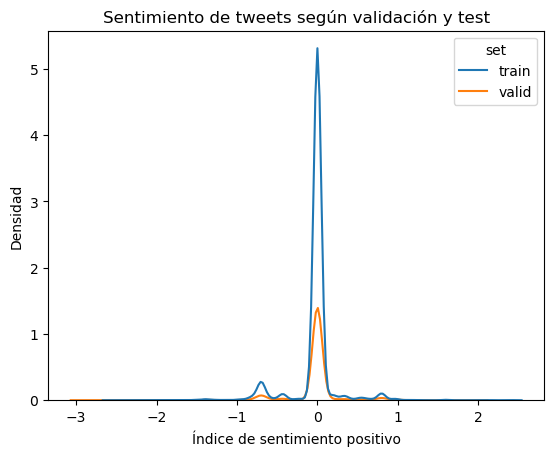

In [61]:
sns.kdeplot(x=df['sentiment'], hue=df['set'])
plt.title("Sentimiento de tweets según validación y test")
plt.xlabel("Índice de sentimiento positivo")
plt.ylabel("Densidad")

# también parecen similares
plt.show()

In [62]:
numerical_var_cat1 = df.loc[df['label'] == 0, 'sentiment']
numerical_var_cat2 = df.loc[df['label'] == 1, 'sentiment']

t_stat, p_val = ttest_ind(numerical_var_cat1, numerical_var_cat2)

print('T-Statistic:', t_stat)
print('P-Value:', p_val)
# parece que las muestras no se diferencian ni tomando un IC del 90%: el sentimiento no parece muy relevante para la predicción, pero lo incluiremos por si acaso 

T-Statistic: 1.6224430699996641
P-Value: 0.10474792695021708


<AxesSubplot:xlabel='sentiment', ylabel='Density'>

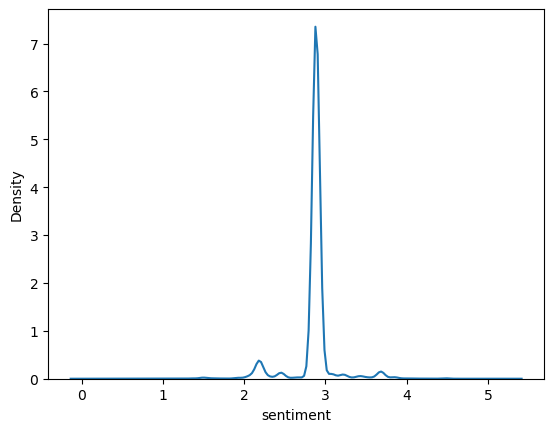

In [65]:
# modifico los valores de sentimiento para poder usar naive bayes abajo (no admite valores negativos):
import numpy as np
min_sentiment = np.min(df['sentiment'].values)
df['sentiment'] = df['sentiment'].apply(lambda x: x - min_sentiment)
sns.kdeplot(x=df['sentiment'])

#### división train-test y vectorización

In [66]:
df_train = df[df['set'] == 'train']
df_test = df[df['set'] == 'valid']

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase=False, min_df=0.001, ngram_range=(1,3), tokenizer=limpiar_tokenizar)

# Fit the vectorizer to the training data and transform it
vector_train = vectorizer.fit_transform(df_train['tweet_text'])

# Transform the testing data using the same vocabulary and IDF weights as the training data
vector_test = vectorizer.transform(df_test['tweet_text'])

C:\Users\mromg\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [68]:
vector_test.shape[0]

2000

In [69]:
vector_test

<2000x2867 sparse matrix of type '<class 'numpy.float64'>'
	with 24411 stored elements in Compressed Sparse Row format>

In [70]:
# por si queremos ver la matriz
arr = vector_test.toarray()

unique_values, value_counts = np.unique(arr, return_counts=True)

value_dict = dict(zip(unique_values, value_counts))

# Print the dictionary
print(value_dict)

{0.0: 5709589, 0.04387803941273762: 1, 0.04546014748281441: 1, 0.05075915573607862: 1, 0.05870649153117638: 1, 0.05959972353121932: 1, 0.05971931373700163: 1, 0.060173169453403536: 1, 0.06023809955869742: 1, 0.06359335710236541: 1, 0.06436464798529014: 1, 0.06452930711707579: 1, 0.0649503565489707: 1, 0.0656948387409846: 1, 0.06700421868796735: 1, 0.06761779676447123: 1, 0.06901332991728919: 1, 0.06914018748742501: 1, 0.07015614746089269: 1, 0.07060530119994135: 1, 0.07075129181373671: 1, 0.0707963718003006: 1, 0.07110471454506692: 1, 0.07135270122034043: 1, 0.07148429068891916: 1, 0.07149530439622073: 1, 0.071531745382397: 1, 0.07173565242541911: 1, 0.07194309851125523: 1, 0.07239925320400184: 1, 0.07240834574824807: 1, 0.072411173288932: 1, 0.07246926688286487: 1, 0.07248390195323921: 1, 0.07274357488329135: 1, 0.07300900847609314: 1, 0.07341515548765581: 1, 0.07345544013548372: 1, 0.07363791738328242: 1, 0.07410984976149268: 1, 0.07422113284206344: 1, 0.07438432725371583: 1, 0.07438

### 3. Modelización

#### añadir longitud del token y nivel de sentimiento al los X del modelo

In [71]:
import scipy as sp
extra_features1 = df_train[['sentiment']]
extra_features2 = df_train[['number_tokens']]

X_train = sp.sparse.hstack((vector_train,extra_features1.values),format='csr')
X_train = sp.sparse.hstack((X_train,extra_features2.values),format='csr')

extra_features1 = df_test[['sentiment']]
extra_features2 = df_test[['number_tokens']]
X_test = sp.sparse.hstack((vector_test,extra_features1.values),format='csr')
X_test = sp.sparse.hstack((X_test,extra_features2.values),format='csr')

y_train = df_train['label']
y_test = df_test['label']

#### oversampling con smote para balancear la muestra

In [72]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train.toarray(), y_train)

#### entrenamiento

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test dataset
y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))

# en principio, el modelo clasifica regular a los tweets que mencionan profesiones, el recall no supera el 60%

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1523
           1       0.86      0.58      0.69       477

    accuracy                           0.88      2000
   macro avg       0.87      0.78      0.81      2000
weighted avg       0.88      0.88      0.87      2000



#### Basándonos en las bases del concurso y en los resultados, elegimos comparar modelos en base al f1-score: https://www.aclweb.org/anthology/2021.smm4h-1.3.pdf

In [89]:
from sklearn.metrics import f1_score
from tqdm import tqdm

def compare_models(X_train, y_train, X_test, y_test, models, clas_score):
    
    # train and evaluate each model on the fixed train and test dataset
    results = []
    for model in tqdm(models, desc='Training and evaluating models'):
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = clas_score(y_test, y_pred, pos_label=1) #recall para 1
            results.append((model, score))
        except:
            print(f"{model} cannot be trained")
            
    # sort the results by score in descending order
    results.sort(key=lambda x: x[1], reverse=True)
    
    return results 

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

models = [
        LogisticRegression(random_state=42),
        LinearSVC(),
        MultinomialNB(),
        GaussianNB(),
        DecisionTreeClassifier(random_state=42),
        RandomForestClassifier(random_state=42),
        AdaBoostClassifier(random_state=42),
        MLPClassifier(random_state=42),
        XGBClassifier(random_state=42),
        LGBMClassifier(random_state=42),
        CatBoostClassifier(random_state=42)
]

results = compare_models(X_train, y_train, X_test, y_test, models, clas_score=f1_score)

results

Training and evaluating models:   0%|                                                           | 0/11 [00:00<?, ?it/s]C:\Users\mromg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Training and evaluating models:   9%|████▋                                              | 1/11 [00:02<00:20,  2.07s/it]C:\Users\mromg\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Training and evaluating models:  36%|██████████████████▌                    

GaussianNB() cannot be trained


Training and evaluating models:  91%|█████████████████████████████████████████████▍    | 10/11 [03:11<00:24, 24.77s/it]

Learning rate set to 0.026592
0:	learn: 0.6802627	total: 62.1ms	remaining: 1m 2s
1:	learn: 0.6678282	total: 121ms	remaining: 1m
2:	learn: 0.6569340	total: 176ms	remaining: 58.6s
3:	learn: 0.6448462	total: 233ms	remaining: 58s
4:	learn: 0.6347271	total: 294ms	remaining: 58.6s
5:	learn: 0.6246191	total: 357ms	remaining: 59.1s
6:	learn: 0.6166428	total: 428ms	remaining: 1m
7:	learn: 0.6094156	total: 494ms	remaining: 1m 1s
8:	learn: 0.6011090	total: 564ms	remaining: 1m 2s
9:	learn: 0.5947854	total: 630ms	remaining: 1m 2s
10:	learn: 0.5878756	total: 695ms	remaining: 1m 2s
11:	learn: 0.5832310	total: 756ms	remaining: 1m 2s
12:	learn: 0.5782438	total: 811ms	remaining: 1m 1s
13:	learn: 0.5717717	total: 867ms	remaining: 1m 1s
14:	learn: 0.5667832	total: 923ms	remaining: 1m
15:	learn: 0.5624268	total: 978ms	remaining: 1m
16:	learn: 0.5587158	total: 1.04s	remaining: 59.9s
17:	learn: 0.5542317	total: 1.1s	remaining: 1m
18:	learn: 0.5496313	total: 1.17s	remaining: 1m
19:	learn: 0.5466158	total: 1.2

163:	learn: 0.3458293	total: 9.66s	remaining: 49.2s
164:	learn: 0.3454770	total: 9.71s	remaining: 49.2s
165:	learn: 0.3447014	total: 9.77s	remaining: 49.1s
166:	learn: 0.3442739	total: 9.83s	remaining: 49s
167:	learn: 0.3436061	total: 9.88s	remaining: 49s
168:	learn: 0.3428105	total: 9.94s	remaining: 48.9s
169:	learn: 0.3424662	total: 10s	remaining: 48.8s
170:	learn: 0.3420186	total: 10.1s	remaining: 48.7s
171:	learn: 0.3414823	total: 10.1s	remaining: 48.7s
172:	learn: 0.3407568	total: 10.2s	remaining: 48.6s
173:	learn: 0.3402686	total: 10.2s	remaining: 48.6s
174:	learn: 0.3398179	total: 10.3s	remaining: 48.5s
175:	learn: 0.3391107	total: 10.3s	remaining: 48.4s
176:	learn: 0.3379643	total: 10.4s	remaining: 48.4s
177:	learn: 0.3374391	total: 10.5s	remaining: 48.3s
178:	learn: 0.3370808	total: 10.5s	remaining: 48.3s
179:	learn: 0.3364381	total: 10.6s	remaining: 48.2s
180:	learn: 0.3359097	total: 10.6s	remaining: 48.1s
181:	learn: 0.3354798	total: 10.7s	remaining: 48.1s
182:	learn: 0.3348

323:	learn: 0.2846642	total: 19s	remaining: 39.6s
324:	learn: 0.2843841	total: 19s	remaining: 39.5s
325:	learn: 0.2839917	total: 19.1s	remaining: 39.5s
326:	learn: 0.2837006	total: 19.2s	remaining: 39.4s
327:	learn: 0.2835001	total: 19.2s	remaining: 39.4s
328:	learn: 0.2832454	total: 19.3s	remaining: 39.3s
329:	learn: 0.2830782	total: 19.3s	remaining: 39.2s
330:	learn: 0.2826260	total: 19.4s	remaining: 39.2s
331:	learn: 0.2824500	total: 19.4s	remaining: 39.1s
332:	learn: 0.2821825	total: 19.5s	remaining: 39.1s
333:	learn: 0.2818899	total: 19.6s	remaining: 39s
334:	learn: 0.2817172	total: 19.6s	remaining: 39s
335:	learn: 0.2813793	total: 19.7s	remaining: 38.9s
336:	learn: 0.2811209	total: 19.7s	remaining: 38.9s
337:	learn: 0.2807818	total: 19.8s	remaining: 38.8s
338:	learn: 0.2805447	total: 19.9s	remaining: 38.7s
339:	learn: 0.2803149	total: 19.9s	remaining: 38.7s
340:	learn: 0.2800559	total: 20s	remaining: 38.6s
341:	learn: 0.2798156	total: 20s	remaining: 38.6s
342:	learn: 0.2796502	to

483:	learn: 0.2412981	total: 28.4s	remaining: 30.3s
484:	learn: 0.2408716	total: 28.5s	remaining: 30.3s
485:	learn: 0.2407760	total: 28.6s	remaining: 30.2s
486:	learn: 0.2406096	total: 28.6s	remaining: 30.2s
487:	learn: 0.2405522	total: 28.7s	remaining: 30.1s
488:	learn: 0.2404320	total: 28.7s	remaining: 30s
489:	learn: 0.2402375	total: 28.8s	remaining: 30s
490:	learn: 0.2400053	total: 28.9s	remaining: 29.9s
491:	learn: 0.2398223	total: 28.9s	remaining: 29.9s
492:	learn: 0.2396779	total: 29s	remaining: 29.8s
493:	learn: 0.2394743	total: 29s	remaining: 29.7s
494:	learn: 0.2392312	total: 29.1s	remaining: 29.7s
495:	learn: 0.2390171	total: 29.1s	remaining: 29.6s
496:	learn: 0.2389578	total: 29.2s	remaining: 29.6s
497:	learn: 0.2387519	total: 29.3s	remaining: 29.5s
498:	learn: 0.2385967	total: 29.3s	remaining: 29.4s
499:	learn: 0.2385272	total: 29.4s	remaining: 29.4s
500:	learn: 0.2383210	total: 29.4s	remaining: 29.3s
501:	learn: 0.2381765	total: 29.5s	remaining: 29.3s
502:	learn: 0.237909

643:	learn: 0.2144780	total: 38.4s	remaining: 21.2s
644:	learn: 0.2143449	total: 38.4s	remaining: 21.1s
645:	learn: 0.2142031	total: 38.5s	remaining: 21.1s
646:	learn: 0.2140211	total: 38.5s	remaining: 21s
647:	learn: 0.2138630	total: 38.6s	remaining: 21s
648:	learn: 0.2137316	total: 38.6s	remaining: 20.9s
649:	learn: 0.2135806	total: 38.7s	remaining: 20.8s
650:	learn: 0.2134189	total: 38.8s	remaining: 20.8s
651:	learn: 0.2132877	total: 38.8s	remaining: 20.7s
652:	learn: 0.2131561	total: 38.9s	remaining: 20.7s
653:	learn: 0.2131018	total: 38.9s	remaining: 20.6s
654:	learn: 0.2130507	total: 39s	remaining: 20.5s
655:	learn: 0.2130111	total: 39.1s	remaining: 20.5s
656:	learn: 0.2128514	total: 39.1s	remaining: 20.4s
657:	learn: 0.2128043	total: 39.2s	remaining: 20.4s
658:	learn: 0.2126661	total: 39.2s	remaining: 20.3s
659:	learn: 0.2125324	total: 39.3s	remaining: 20.2s
660:	learn: 0.2124021	total: 39.3s	remaining: 20.2s
661:	learn: 0.2123529	total: 39.4s	remaining: 20.1s
662:	learn: 0.2121

803:	learn: 0.1948601	total: 47.8s	remaining: 11.7s
804:	learn: 0.1947093	total: 47.8s	remaining: 11.6s
805:	learn: 0.1945471	total: 47.9s	remaining: 11.5s
806:	learn: 0.1944302	total: 48s	remaining: 11.5s
807:	learn: 0.1943395	total: 48s	remaining: 11.4s
808:	learn: 0.1942516	total: 48.1s	remaining: 11.4s
809:	learn: 0.1942078	total: 48.1s	remaining: 11.3s
810:	learn: 0.1941850	total: 48.2s	remaining: 11.2s
811:	learn: 0.1940604	total: 48.3s	remaining: 11.2s
812:	learn: 0.1939549	total: 48.3s	remaining: 11.1s
813:	learn: 0.1938589	total: 48.4s	remaining: 11.1s
814:	learn: 0.1938226	total: 48.4s	remaining: 11s
815:	learn: 0.1936637	total: 48.5s	remaining: 10.9s
816:	learn: 0.1935108	total: 48.6s	remaining: 10.9s
817:	learn: 0.1933912	total: 48.6s	remaining: 10.8s
818:	learn: 0.1933528	total: 48.7s	remaining: 10.8s
819:	learn: 0.1932108	total: 48.7s	remaining: 10.7s
820:	learn: 0.1931925	total: 48.8s	remaining: 10.6s
821:	learn: 0.1930590	total: 48.9s	remaining: 10.6s
822:	learn: 0.1928

963:	learn: 0.1795421	total: 57.2s	remaining: 2.13s
964:	learn: 0.1794313	total: 57.3s	remaining: 2.08s
965:	learn: 0.1794113	total: 57.3s	remaining: 2.02s
966:	learn: 0.1792960	total: 57.4s	remaining: 1.96s
967:	learn: 0.1791892	total: 57.4s	remaining: 1.9s
968:	learn: 0.1791556	total: 57.5s	remaining: 1.84s
969:	learn: 0.1790515	total: 57.5s	remaining: 1.78s
970:	learn: 0.1789245	total: 57.6s	remaining: 1.72s
971:	learn: 0.1788376	total: 57.7s	remaining: 1.66s
972:	learn: 0.1787037	total: 57.7s	remaining: 1.6s
973:	learn: 0.1786840	total: 57.8s	remaining: 1.54s
974:	learn: 0.1786643	total: 57.8s	remaining: 1.48s
975:	learn: 0.1783788	total: 57.9s	remaining: 1.42s
976:	learn: 0.1782879	total: 57.9s	remaining: 1.36s
977:	learn: 0.1782096	total: 58s	remaining: 1.3s
978:	learn: 0.1781789	total: 58.1s	remaining: 1.25s
979:	learn: 0.1780137	total: 58.1s	remaining: 1.19s
980:	learn: 0.1779294	total: 58.2s	remaining: 1.13s
981:	learn: 0.1778110	total: 58.2s	remaining: 1.07s
982:	learn: 0.177

Training and evaluating models: 100%|██████████████████████████████████████████████████| 11/11 [04:15<00:00, 23.24s/it]

999:	learn: 0.1765624	total: 59.3s	remaining: 0us


[(AdaBoostClassifier(random_state=42), 0.7212741751990898),
 (LGBMClassifier(random_state=42), 0.7202881152460984),
 (<catboost.core.CatBoostClassifier at 0x1f8bb9e0a60>, 0.7163461538461539),
 (XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                predictor=None, random_state=42, ...),
  0.7113276492082826),
 (RandomFore

In [92]:
model = AdaBoostClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
# cabe resaltar que los resultados son considerablemente peores que los expuestos en el paper arriba

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1523
           1       0.79      0.66      0.72       477

    accuracy                           0.88      2000
   macro avg       0.84      0.80      0.82      2000
weighted avg       0.87      0.88      0.87      2000



In [111]:
from sklearn.model_selection import GridSearchCV
model = AdaBoostClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150], # 50 defecto
    'learning_rate': [0.1, 0.5, 1.0], # 1 defecto
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1') #ajustamos tmb por f1 y hacemos multiprocessing
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Train the model with the best hyperparameters
model = AdaBoostClassifier(n_estimators=grid_search.best_params_['n_estimators'], 
                           learning_rate=grid_search.best_params_['learning_rate'], 
                           random_state=42)
model.fit(X_train, y_train)

# Predict on the test set and print the classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# la búsqueda por gridsearch no ha mejorado el modelo por defecto

Best parameters:  {'learning_rate': 1.0, 'n_estimators': 150}
Best score:  0.897277912431006
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1523
           1       0.81      0.64      0.71       477

    accuracy                           0.88      2000
   macro avg       0.85      0.79      0.82      2000
weighted avg       0.87      0.88      0.87      2000

